In [1]:
import pandas as pd
import numpy as np
import sys
import os
import time
import random
import copy
import math
import scanpy as sc
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns
params = {
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': "Helvetica",
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }

mpl.rcParams.update(params)
sns.set_style("ticks")
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0, "transparent": True}
mpl.rc('savefig', dpi=300)
output_dir = "outs"
output_suffix = ""
output_formats = [".png", ".pdf"]
def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

data_dir = "../data/"

In [2]:
sc.set_figure_params(color_map='viridis')

## Analyze Cell Cycle status of Tabula Bursa

#### Load Data

In [3]:
# contains a portion of tabula bursa that my computer can handle and the B cells from swift et. al
adata = sc.read_h5ad('by_tissue_qc/outputs/bcells_BCD.h5ad')
adata.obs_names_make_unique(join="_")

/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### generally balance the cell types
This is not strictly, necessary but it helps prevent bias in identifying genes associated with the identities of cycling and non-cycling cells, rather than cell cylce per se

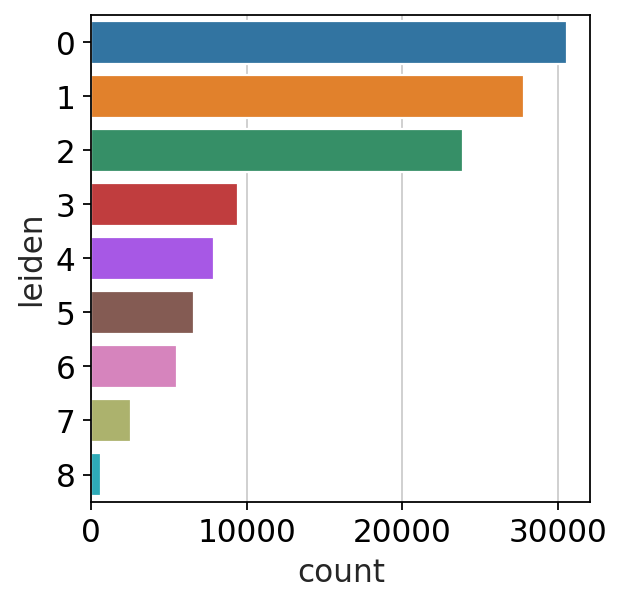

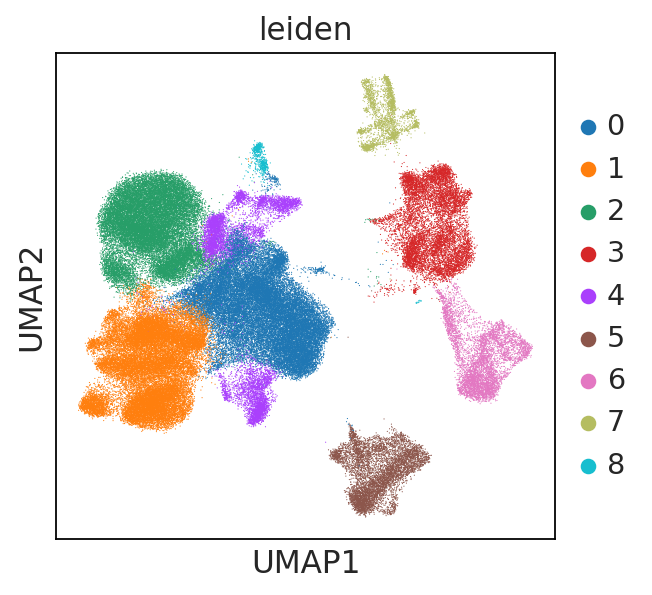

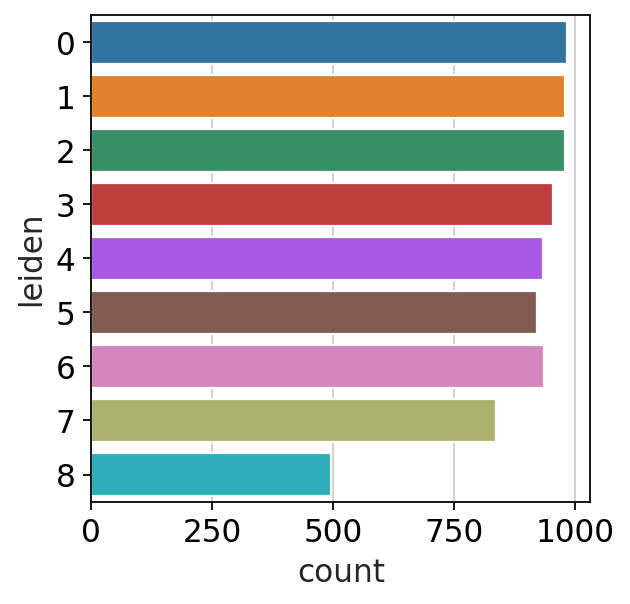

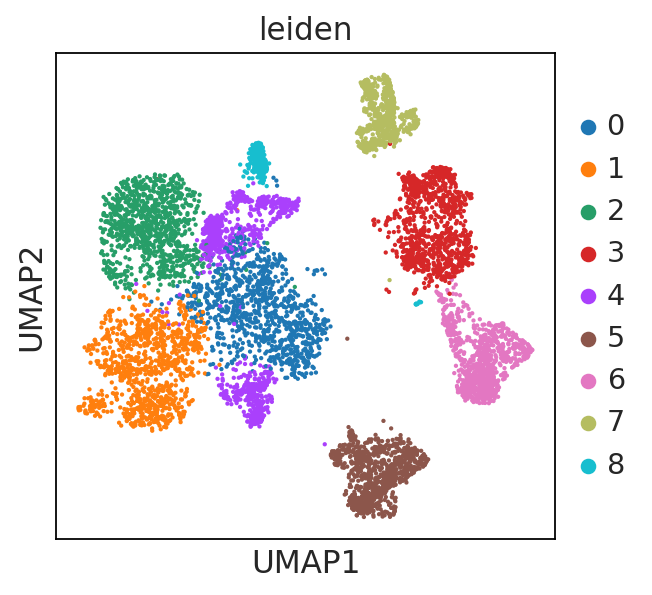

In [4]:
balance_celltypes = True
cluster = 'leiden'
#print(adata.obs[cluster].value_counts(), 'cells in current leiden clusters')
fig, ax = plt.subplots(1,1)
sns.countplot(data=adata.obs, y = adata.obs[cluster])
sc.pl.umap(adata, color = cluster)
if balance_celltypes:
    cell_names = adata.obs.groupby(cluster).sample(n=1000, replace=True).index
    adata = adata[adata.obs.index.isin(cell_names)]
    #print(adata.obs[cluster].value_counts(), 'more balanced cells in each cluster')
fig, ax = plt.subplots(1,1)
sns.countplot(data=adata.obs, y = adata.obs[cluster])
sc.pl.umap(adata, color = cluster)

# Annotation of cell cylce Using Gita's method

In [12]:
# Create cycling score:
#S markers
lst_sub_1 = ['ABHD10','CCDC14','CDKN2AIP','NT5DC1','SVIP','PTAR1']
#G2M markers
lst_sub_2 = ['SMC4','TMPO','LMNB1','HINT3']
#M markers
lst_sub_3 = ['HMG20B','HMGB3','HPS4']
#G2 markers
lst_sub_4 = ['ANKRD36C','YEATS4','DCTPP1']
#G1S marker
lst_sub_5 = ['CEP57','CDCA7L']
#G0 marker
lst_sub_6 = ['CDKN1A','CDKN1B','CDKN1C']

# How could the best score that you make be related to Gita's score, and how strongly expressed are these genes?
final_lst = lst_sub_1 + lst_sub_2 + lst_sub_3 + lst_sub_4 + lst_sub_5 + lst_sub_6
cycling = lst_sub_1 + lst_sub_2 + lst_sub_3 + lst_sub_4 + lst_sub_5 
sc.tl.score_genes(adata, cycling, score_name = 'cycling', use_raw=True)
sc.tl.score_genes(adata, lst_sub_6, score_name = 'non-cycling',use_raw=True)

def scoring(cycling, non_cycling):
    if cycling == non_cycling:
        decision = 'not clear'
    elif cycling > non_cycling:
        decision = 'cycling'
    else:   
        decision = 'non-cycling'
    return(decision)


#same as above but for total dataset
adata.obs['decision']= adata.obs.apply(lambda row: scoring(row['cycling'], row['non-cycling']), axis=1)
#collecting only cells for which a decision could be made
dataCyc10=adata[adata.obs['decision']!='not clear']
print('fraction of cells with clear calls:', dataCyc10.shape[0]/adata.shape[0])

adata.obs.decision.value_counts()

/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


fraction of cells with clear calls: 1.0


/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


cycling        4522
non-cycling    3500
Name: decision, dtype: int64

## Plot the Distributions of cell cycle scores

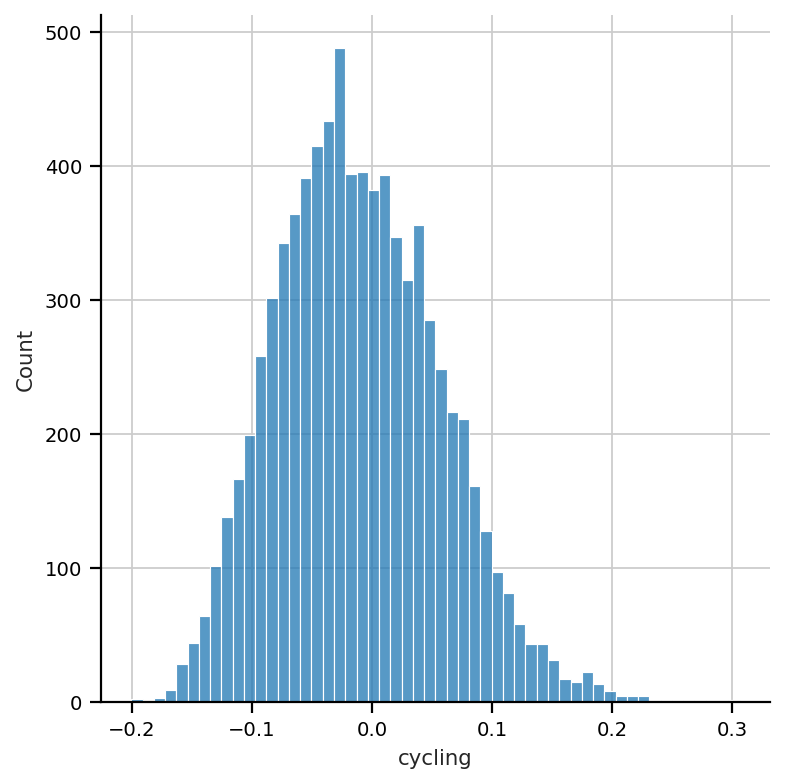

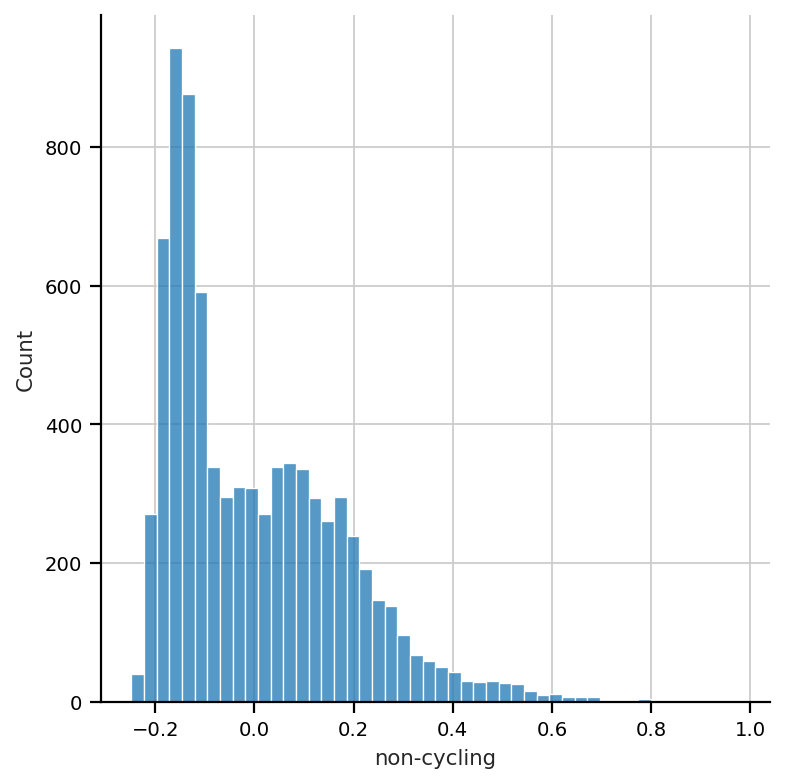

In [13]:
sns.displot(adata.obs['cycling'])
sns.displot(adata.obs['non-cycling'])

cycling score looks very noisy as it is centered around 0, non-cycling score seems to have 2 modes which is good

## plot cell type labels onto these histograms to see if it checks out with biology

In [14]:
# filter low abundance cell groups to clean up the plots (less lines)
# remove the dual labels
cell_group = 'majority_voting'
filter_low_abundance_cell_groups = True
adata.obs[cell_group] = adata.obs[cell_group].str.split("|", expand = True).iloc[:,0].astype('category')
if filter_low_abundance_cell_groups:
    select = adata.obs[cell_group].value_counts() > 100
    adata = adata[adata.obs[cell_group].isin(select[select == True].index)]

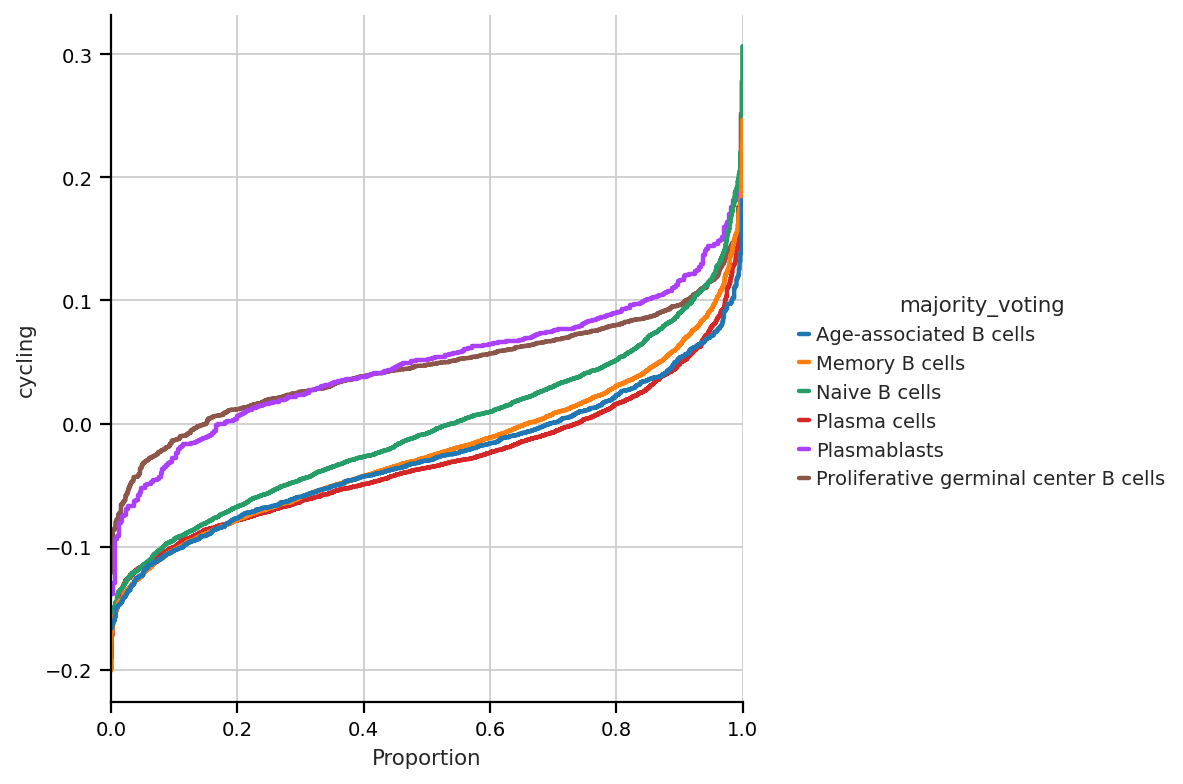

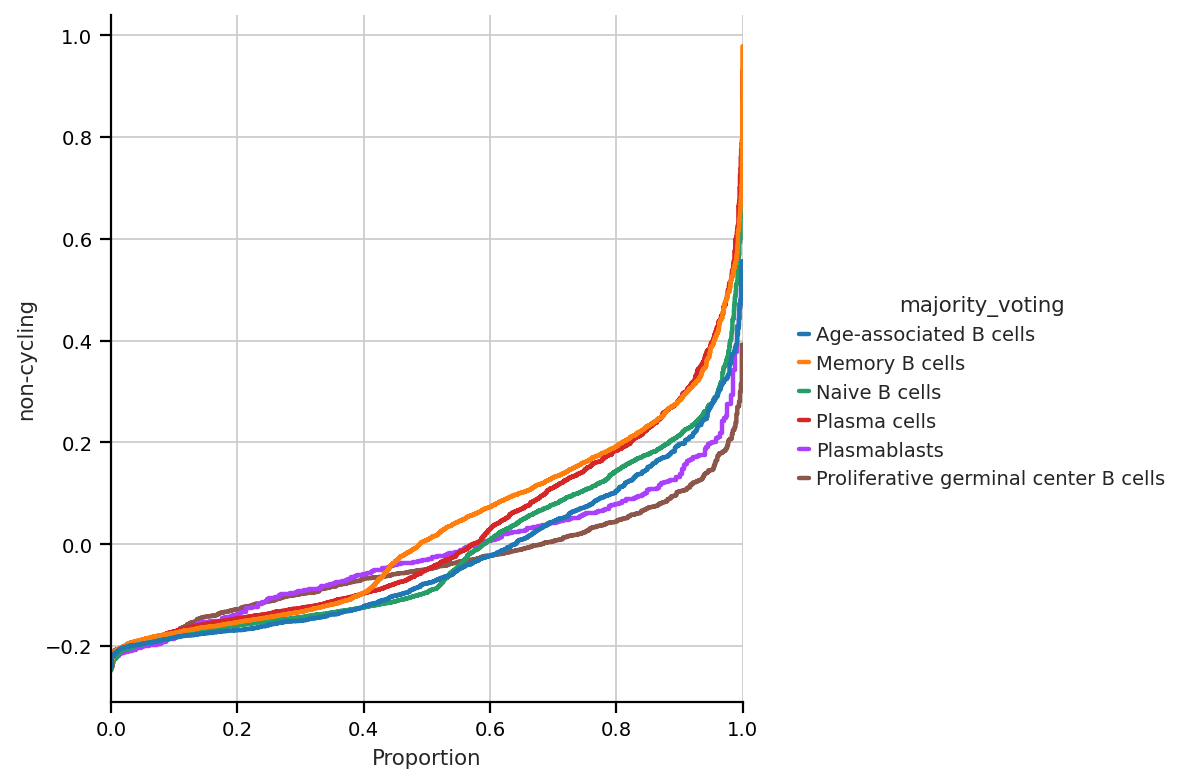

In [15]:
data = adata.obs
sns.displot(data = data, y = 'cycling', hue = 'majority_voting', kind = 'ecdf', lw = 2)
sns.displot(data = data, y = 'non-cycling', hue = 'majority_voting', kind = 'ecdf', lw = 2)

You do see some separation between the cycling cells and the non-cycling cells, but the signal is may be weak

## Plotting the joint distributions of Gita's Scores

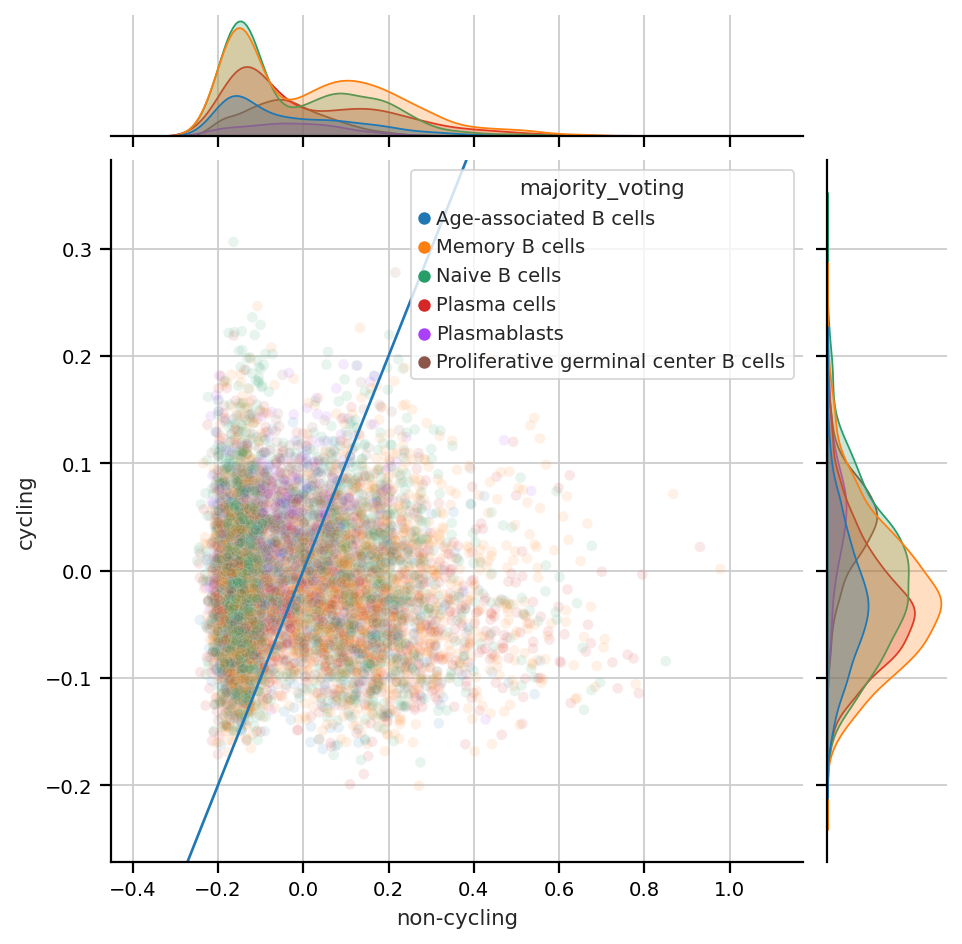

In [51]:
g = sns.jointplot(data = data, y = 'cycling', x = 'non-cycling', hue = 'majority_voting', lw = 2, alpha = 0.1)
g.ax_joint.axline((0, 0), slope=1)

# Annotate Cell Cycle via covariation Method

### Calculate the full correlation matrix of all genes

In [6]:
df = adata.to_df()

# convert cell x gene matrix to df
#df = convert_sparse_to_dataframe(adata)
# Use Numpy to do the Pearson Correllation of all values
# Did this because pandas corr is very slow, must be a bug.. 
# rowvar false means that genes are being correllated
df_corr = np.corrcoef(df.values, rowvar=False) 
# Put the labels back on and make it a df
df_corr = pd.DataFrame(df_corr, index = df.columns, columns=df.columns)
# Check that the matrix looks correct
df_corr.head()

In [7]:
GOI = 'MKI67'

### ECDF of pearson correlations of genes with Gene of interest

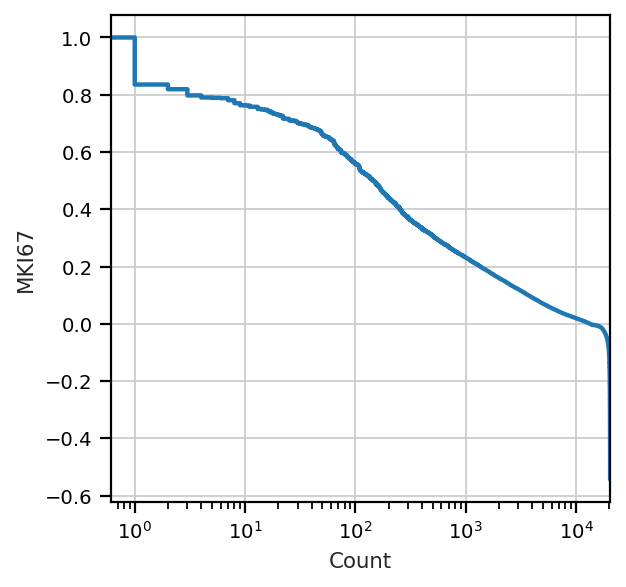

In [8]:
sns.set_context('paper')
g = sns.ecdfplot(y = df_corr[GOI], complementary=True, stat='count', lw = 2)
g.set_xscale('log')
print(df_corr[GOI].sort_values(ascending = True)[:10])

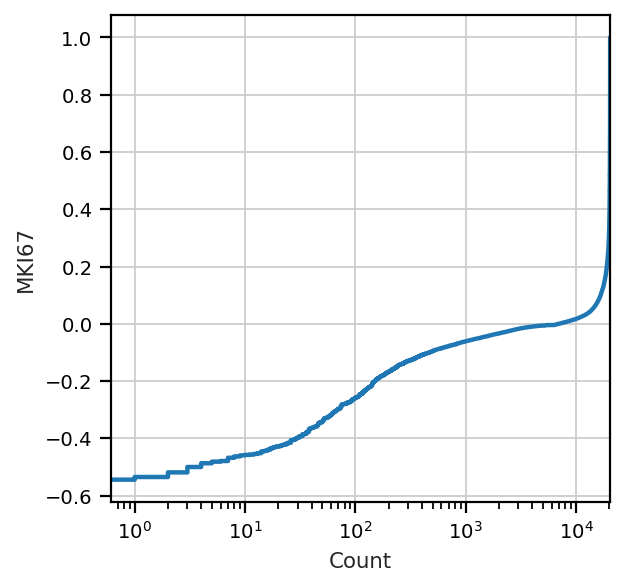

In [9]:
g = sns.ecdfplot(y = df_corr[GOI], complementary=False, stat='count', lw = 2)
g.set_xscale('log')
print(df_corr[GOI].sort_values(ascending = False)[:10])

Looks like hundreds of genes covary quite strongly with MKI67, let's peep the top 20 magnitidue pearson correlations

Seems that anti-correlated genes are a combo of B cell markers and anti profliferative genes e.g. DUSP1 and TSC22D3
Seems that correlated genes are related to the cell cycle e.g. TYMS, TPX2, AURKB

# Define Feature Set for Cell Cycle by taking strongest covarying Genes

In [11]:
# arbitraty cutoffs
cutoff = 0.5ax.axline((0, 0), slope=1)
cutoff_neg = -0.2

# all above cutoff
cell_cycle_genes = list(df_corr[df_corr[GOI] > cutoff][GOI].sort_values(ascending = False).index)

anti_cell_cycle_genes = list(df_corr[df_corr[GOI] < cutoff_neg][GOI].sort_values(ascending = False).index)

# balance the total amounts of each gene type
total_cc = len(cell_cycle_genes)
total_acc = len(anti_cell_cycle_genes)
if  total_cc <= total_acc:
    anti_cell_cycle_genes = anti_cell_cycle_genes[:total_cc]
else:
    cell_cycle_genes = cell_cycle_genes[:total_acc] 

# construct df to hold gene feature set 

cc = pd.DataFrame([cell_cycle_genes, anti_cell_cycle_genes]).T

cc.columns = ['cc', 'anti_cc']

cc.to_csv('cell_cycle_genes.tab', sep = "\t")

cell_cycle_genes = pd.read_table('cell_cycle_genes.tab', index_col=0)

In [17]:
# use a feature set that is the same size as the one Gita picked:
same_length = False
# use a larger feature set
genes_contributing_to_score = 20
if same_length:
    sc.tl.score_genes(adata, gene_list=cell_cycle_genes.loc[:len(cycling), 'cc'], score_name='correlation_cycling')
    sc.tl.score_genes(adata, gene_list=cell_cycle_genes.loc[:len(cycling), 'anti_cc'], score_name='anticorrelation_cycling')
else:
    sc.tl.score_genes(adata, gene_list=cell_cycle_genes.loc[:genes_contributing_to_score, 'cc'], score_name='correlation_cycling')
    sc.tl.score_genes(adata, gene_list=cell_cycle_genes.loc[:genes_contributing_to_score, 'anti_cc'], score_name='anticorrelation_cycling')


adata.obs['ms_cycling'] = adata.obs['correlation_cycling'] > 0.1

cycling_mapper = {True:'cycling', False:'non-cycling'}

adata.obs['ms_cycling'] = adata.obs['ms_cycling'].map(cycling_mapper)

/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(
/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


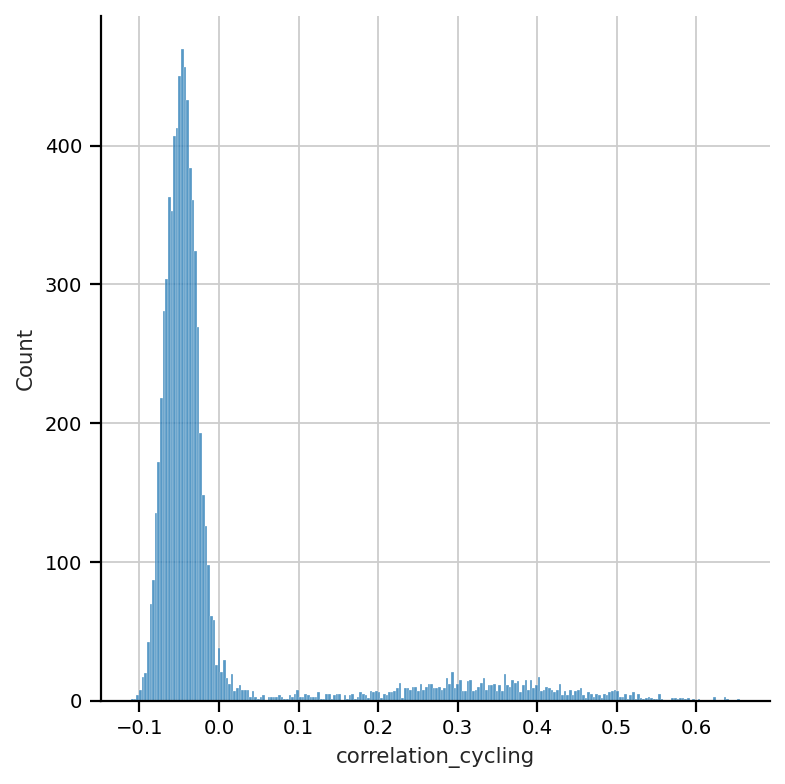

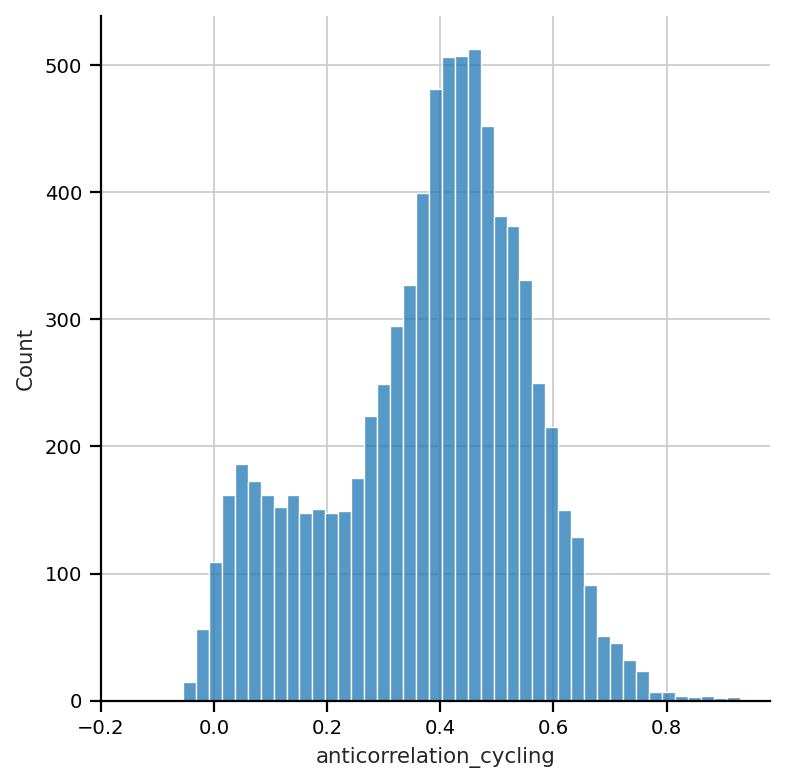

In [18]:
sns.displot(adata.obs['correlation_cycling'])
sns.displot(adata.obs['anticorrelation_cycling'])

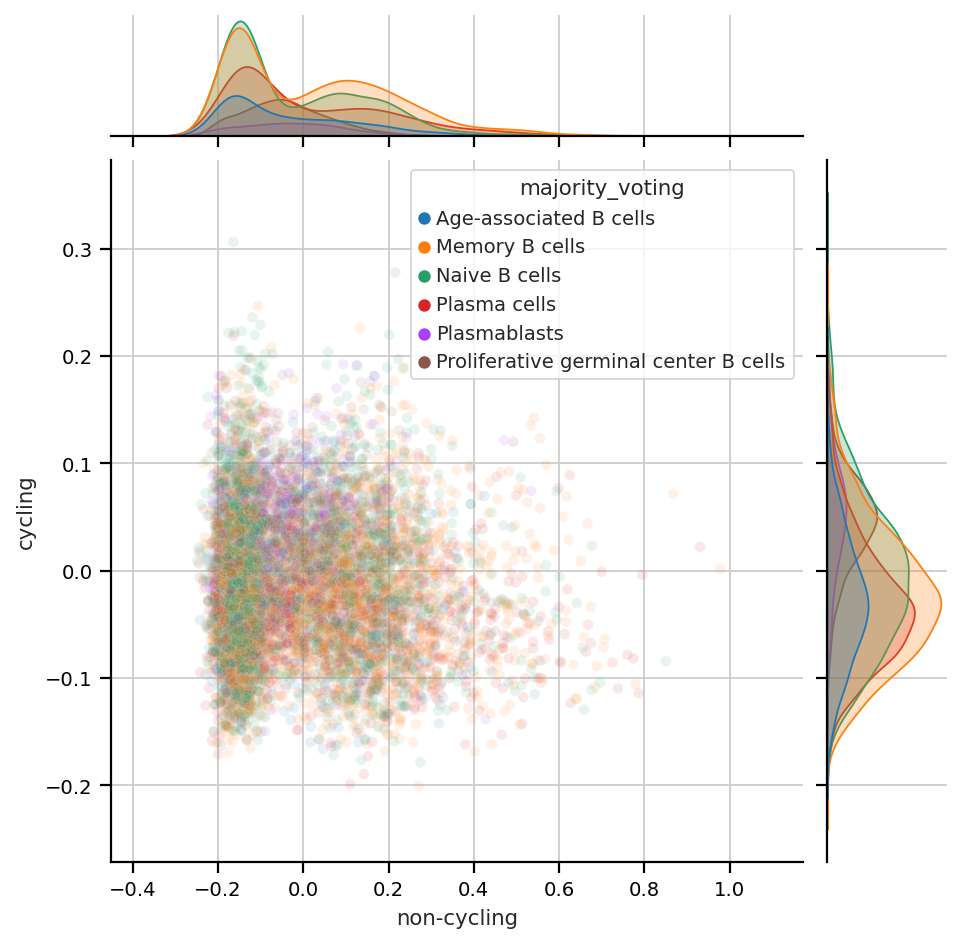

In [19]:
sns.jointplot(data = data, y = 'cycling', x = 'non-cycling', hue = 'majority_voting', lw = 2, alpha = 0.1)

## plot cell type labels onto these histograms to see if it checks out with biology

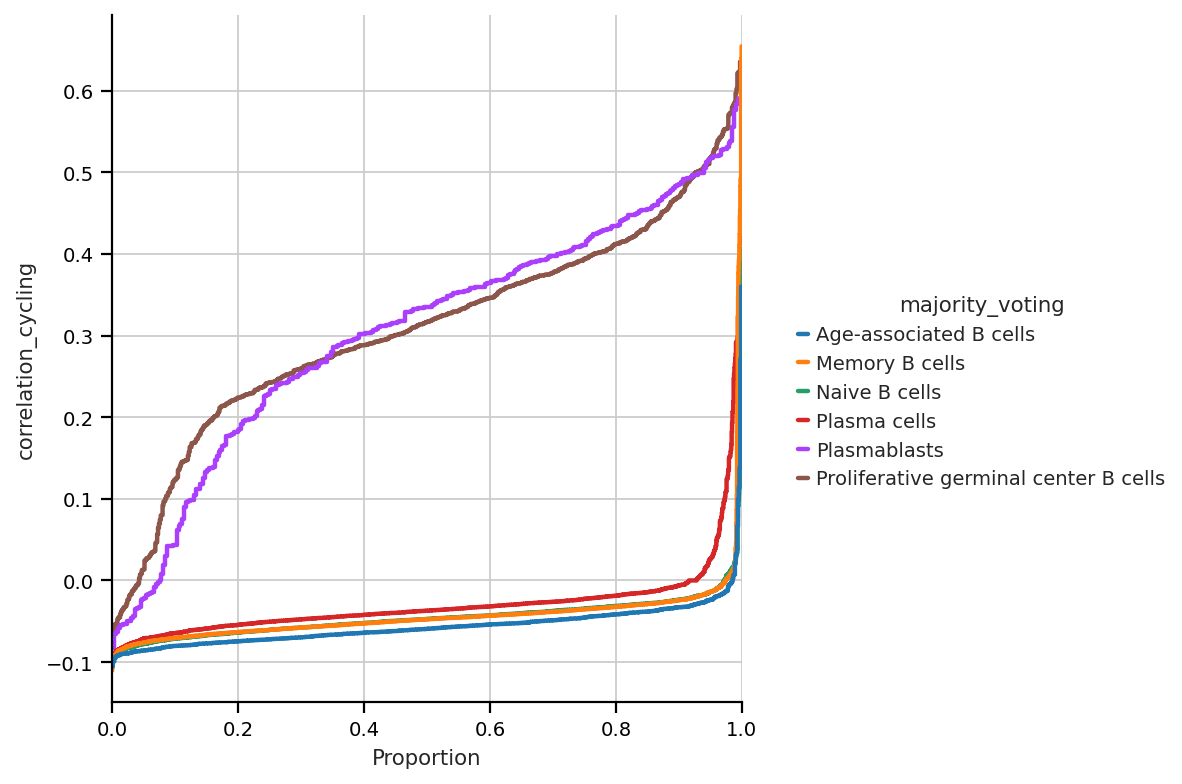

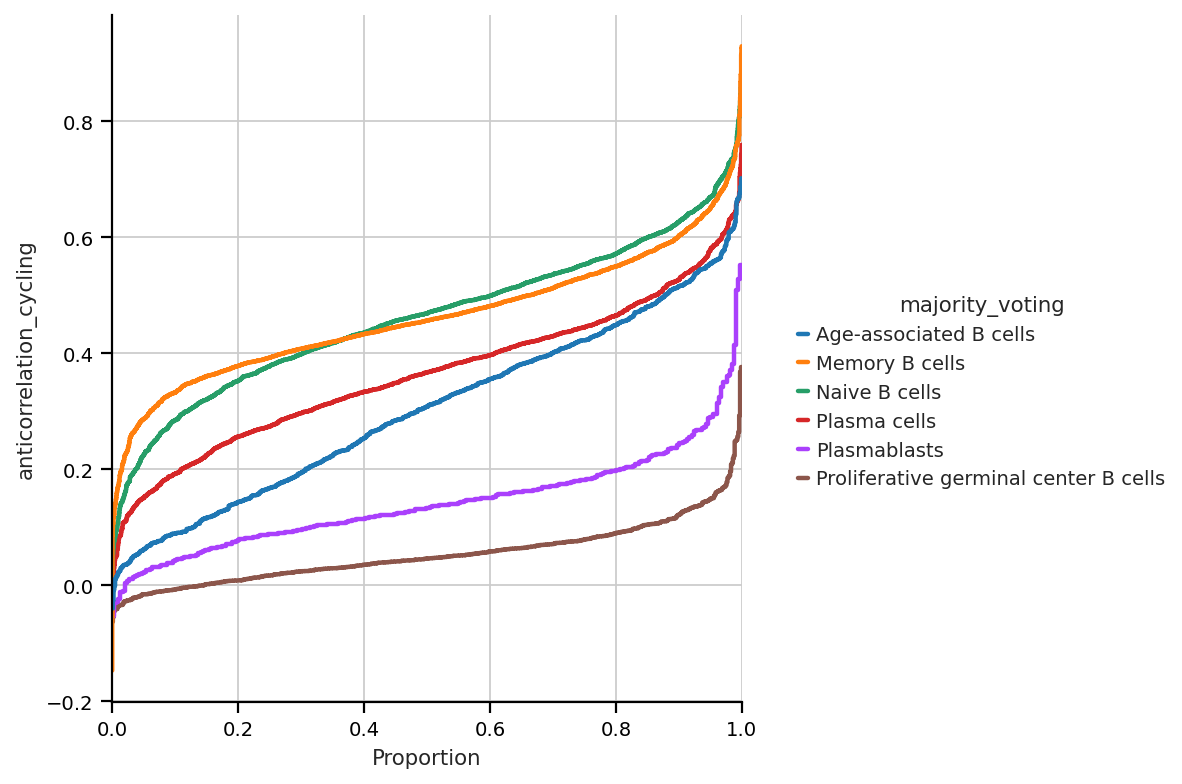

In [20]:
data = adata.obs
sns.displot(data = data, y = 'correlation_cycling', hue = 'majority_voting', kind = 'ecdf', lw = 2)
sns.displot(data = data, y = 'anticorrelation_cycling', hue = 'majority_voting', kind = 'ecdf', lw = 2)

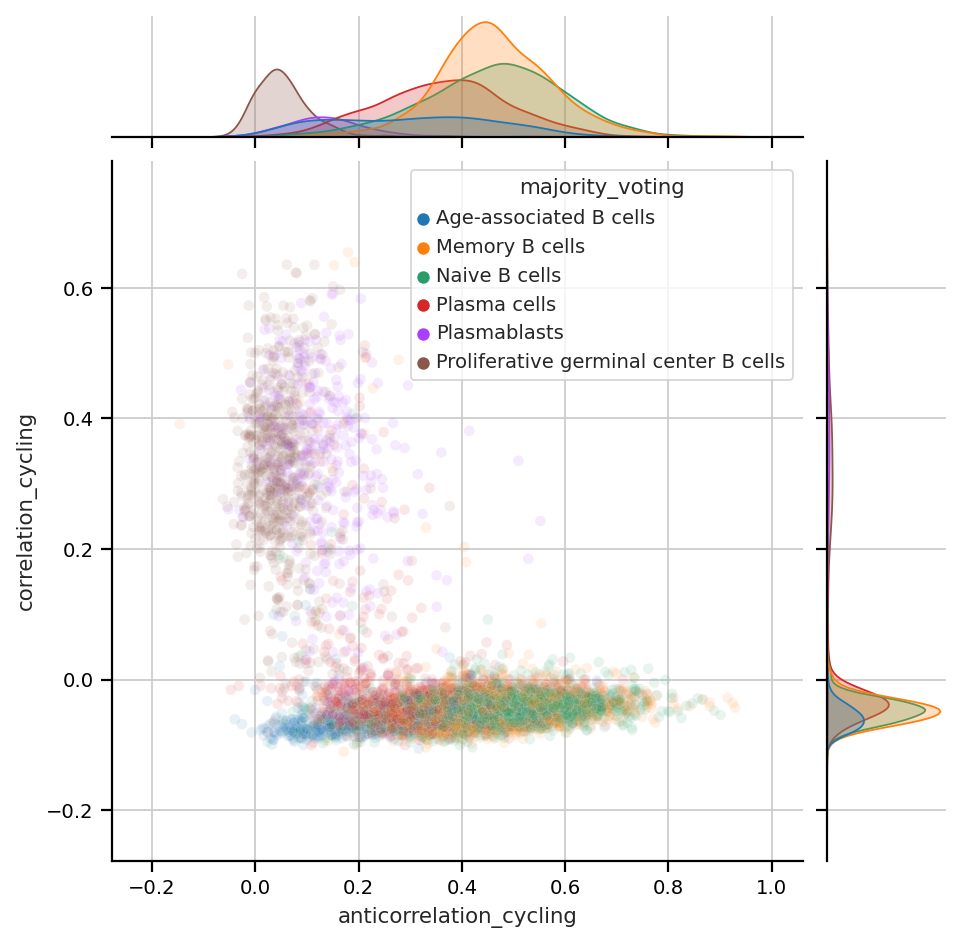

In [22]:
sns.jointplot(data = data, y = 'correlation_cycling', x = 'anticorrelation_cycling', hue = 'majority_voting', lw = 2, alpha = 0.1)

So here using the correlation approach, I can see a major problem with following Gita's lead and subtracting the scores because many of the anticorrelated genes I've identified are associated with Naive and Memory B cell identity, thus the plasma cells end up in the fourth quadrant, they certainly aren't cycling but they also aren't anti-cycling, I think it makes most sense to just use the positively correlated genes, but one good instead prune the anti-correlated genes to identify more relevant features to plasma cell anti-cycling and remove Mem/Naive identity genes

#  Plot classification schemes against each other

<AxesSubplot:xlabel='decision', ylabel='ms_cycling'>

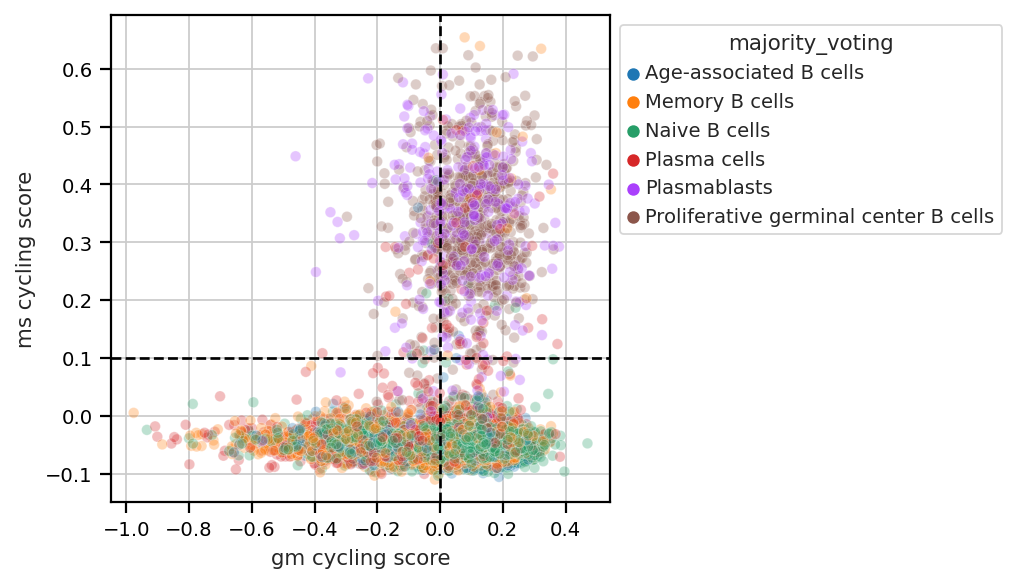

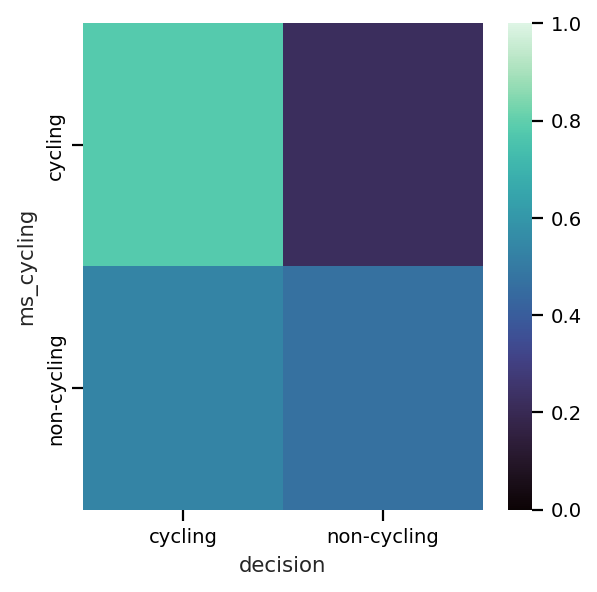

In [57]:
fig, ax = plt.subplots(1,1)
sns.scatterplot(adata.obs, x = adata.obs['cycling'] - adata.obs['non-cycling'], y = adata.obs['correlation_cycling'], alpha = 0.3, hue = adata.obs['majority_voting'])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel('gm cycling score')
plt.ylabel('ms cycling score')
plt.axvline(x=0, ls = "--", c = 'k')
plt.axhline(y=0.1, ls = "--", c = 'k')
fig, ax = plt.subplots(1,1)
cmtx = sc.metrics.confusion_matrix("ms_cycling", "decision", adata.obs)
sns.heatmap(cmtx, cmap='mako', vmax = 1 , vmin = 0)

### Plotting all four scores against each other 

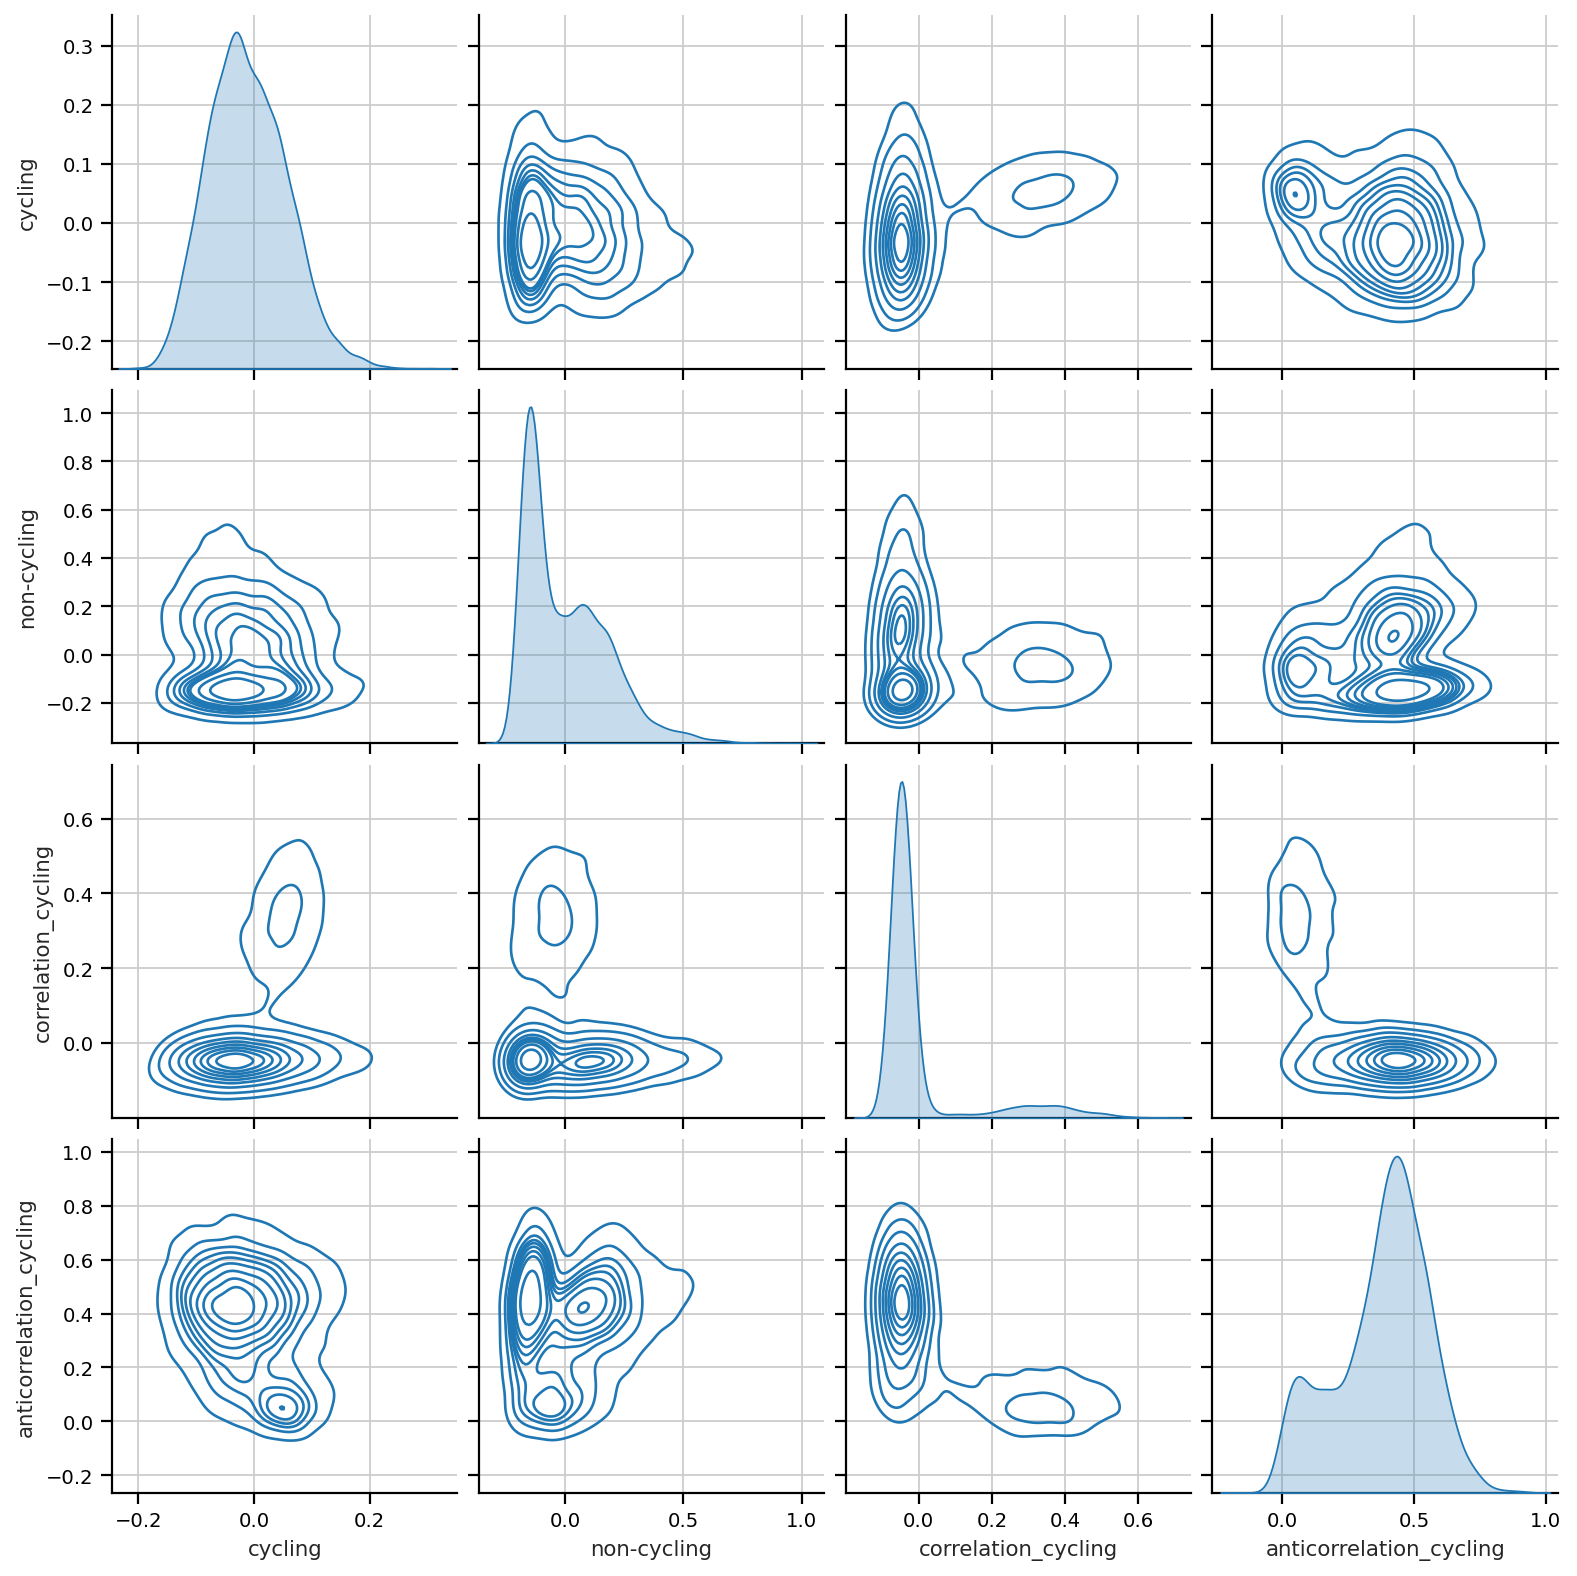

In [25]:
x_vars = ['cycling', 'non-cycling', 'correlation_cycling', 'anticorrelation_cycling']
y_vars = ['cycling', 'non-cycling', 'correlation_cycling', 'anticorrelation_cycling']
sns.pairplot(data = adata.obs, x_vars=x_vars, y_vars=y_vars, kind="kde")